In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

import matplotlib.pyplot as plt

import numpy as onp

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline



# Using an RDF as a scoring function. 

An EDM could come from points in many dimensions, so it's possible that there are multiple weird ways to satisfy any given EDM. These ways would all be consistent with other EDMs, and so the network will be happy, but the actual 3D realisation of those EDMs might _do not_ work how we expect. 

Alternatively, if we directly learn 3D coordinates, and then compare the euclidean distances to a known distribution, then the network is forced to make the distances consistent with what we expect in 3D space. Put another way, the network can't just put all atoms at the same distance as a carbon-carbon bond distance, because there is not enough volume in 3d dimensions to fit all the atoms surrounding the central atom. The surrounding atoms will thus be forced to move outwards, and hopefully it all settles on a reasonable-looking molecule.  

The below fits a loss function using the distributions of known atom distances. 

The network part uses JAX numpy, hence the original numpy is re-nicknamed `onp`.

In [2]:
##load dataset of QM9 isomers. 
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

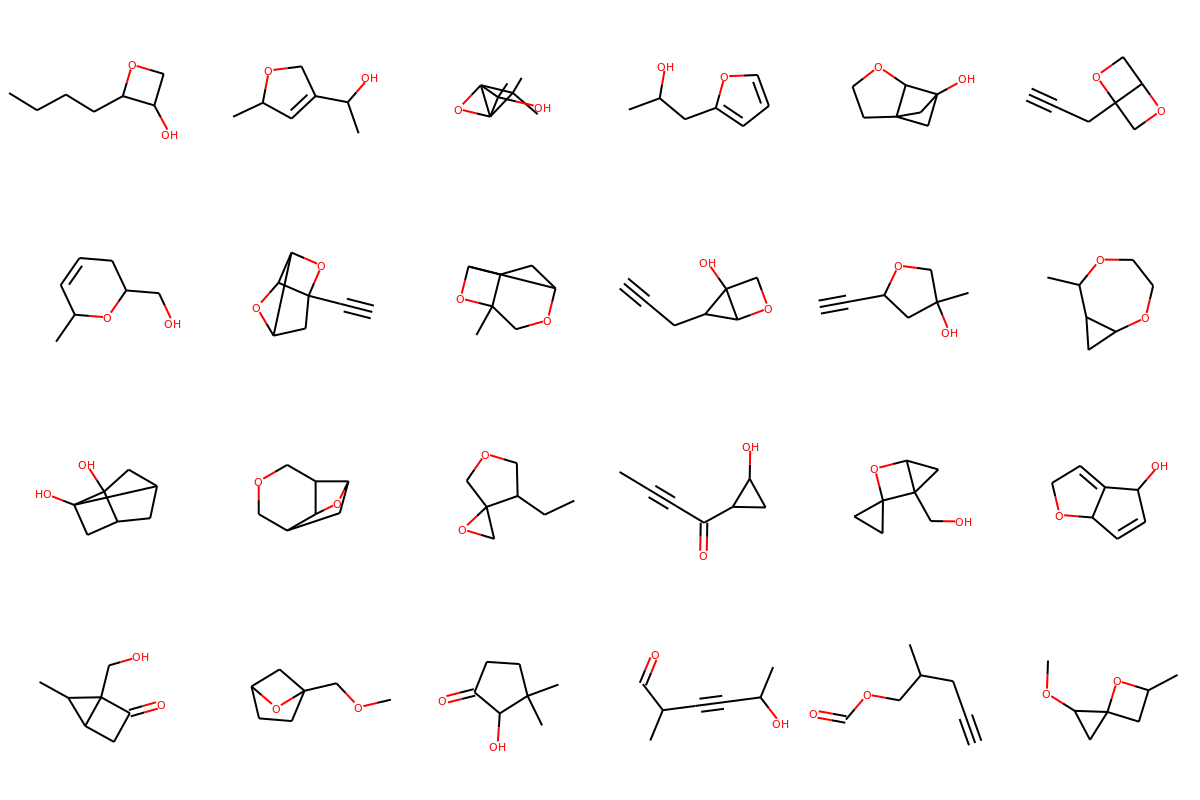

In [3]:
###draw sample
Draw.MolsToGridImage(onp.random.choice(onp.array(mols), 24), molsPerRow=6)


In [4]:
###Calculates 3d coordinates of a molecule using RDKit, and then gets a euclidean distance matrix. 
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
##Less necessary here, but keeping it around as it may be used later. 
##This permutes the indices of the atoms so you don't always have 
##sequental atoms bonded to each other - the 'bonded' distances in the EDM
##should be able to appear anywhere on the board. 
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = onp.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        onp.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [5]:
###Run through molecules and make the EDM dataset. 
edms = list()
atomidx = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 2000)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = onp.clip(onp.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
        el, al = permute_edm(edm, atoms, num_permutes=10)
        for e, a in zip(el, al):
            edms.append(e)
            atomidx.append(a)

# Radial Distribution Function

This is the same as a histogram of the pairwise euclidean distances. It plots the density of expected distances. As seen below, there are a number of peaks, which we can probably assign to (left to right) directly bonded atoms (about 1.3 angstrom), atoms separated by one bond (2-3A), atoms separated by two bonds, etc... 

Text(0, 0.5, 'Density')

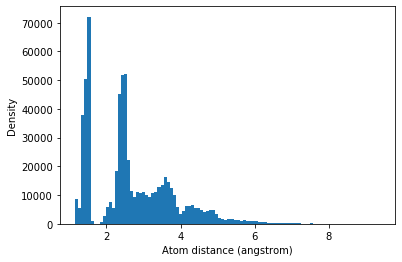

In [6]:
edms = onp.array(edms)
#_ = plt.hist(edms.flatten(), bins=100)
_ = plt.hist(edms.reshape(-1,1), bins=100)
plt.xlabel('Atom distance (angstrom)')
plt.ylabel('Density')

# Can we turn the RDF into a loss function? 

We know the desired RDF. By predicting coordinates with a neural net, we can then generate an RDF for the predicted coordinates (using minibatch to reduce sampling error). Then, just calculate the mean squared error between the predicted coord RDF and true RDF. 

JAX-MD have a handy tool to calculate RDFs which inspired the below. See https://github.com/google/jax-md/blob/master/notebooks/jax_md_cookbook.ipynb

In [13]:
edms_flat = edms.flatten()

In [155]:
import jax.numpy as np
from jax.config import config
from jax import jit, grad, lax, random, vmap
@jit
def calcRDF(flat_distances, bins=200, sigma=0.1):
    exp = np.exp(-0.5 * (flat_distances[:, np.newaxis] -np.linspace(0.1, 10, bins)) ** 2 / sigma** 2)
    gaussian_distances = (exp / np.sqrt(2 * np.pi * sigma ** 2))
    rdf = np.mean(gaussian_distances, axis=0)
    return rdf / np.sum(rdf)*(100)

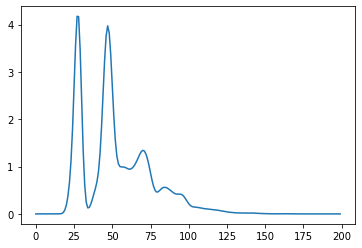

In [156]:
plt.plot(calcRDF(edms_flat))

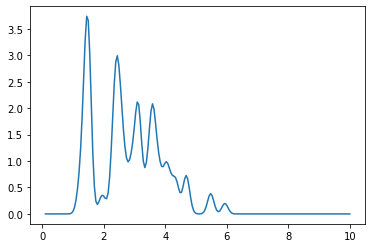

In [157]:
subsample = onp.random.choice(edms_flat, 100)
plt.plot(np.linspace(0.1, 10, 200), calcRDF(subsample))

In [567]:
##Note that at small subsamples, the MSE is large
##due to sampling error. As the subsample size gets
##larger, the subsample better approximates
##the full sample, and MSE is reduced. 
mselist=list()
for i in range(1,40):
    subsample = onp.random.choice(edms_flat, 10*i)
    mse = np.sum(np.power(calcRDF(subsample)-calcRDF(edms_flat), 2))
    mselist.append(mse)
    print('MSE is:', np.mean(np.power(calcRDF(subsample)-calcRDF(edms_flat), 2)))

MSE is: 0.9757141
MSE is: 0.31192237
MSE is: 0.1598282
MSE is: 0.07225988
MSE is: 0.097727336
MSE is: 0.02514329
MSE is: 0.023573719
MSE is: 0.05431856
MSE is: 0.06378062
MSE is: 0.029635368
MSE is: 0.08781105
MSE is: 0.030546077
MSE is: 0.029850025
MSE is: 0.021099245
MSE is: 0.02860815
MSE is: 0.027448384
MSE is: 0.0280483
MSE is: 0.0289348
MSE is: 0.05448209
MSE is: 0.016836604
MSE is: 0.025143426
MSE is: 0.012108156
MSE is: 0.040156137
MSE is: 0.022341574
MSE is: 0.016634798
MSE is: 0.024117429
MSE is: 0.017090382
MSE is: 0.01153911
MSE is: 0.0062266015
MSE is: 0.011385215
MSE is: 0.068228774
MSE is: 0.020950852
MSE is: 0.041994486
MSE is: 0.020098474
MSE is: 0.024153454
MSE is: 0.017540038
MSE is: 0.008694267
MSE is: 0.027114635
MSE is: 0.008157534


# Can we use this loss function in a neural net?

Using jax.stax here for the net. The idea is to generate coordinates from noise (i.e. latent coordinates like a GAN or a VAE) and to take the loss function as defined above (i.e. the inverse of the gmm density)

The code below borrows from two good examples:


There is a great tutorial for doing this: MAML with JAX: https://github.com/ericjang/maml-jax/blob/master/maml.ipynb with more depth explanation at: https://blog.evjang.com/2019/02/maml-jax.html

However some of the code is old. So, also using: https://github.com/google/jax/blob/master/examples/mnist_vae.py which seems more similar to the current task but has no explanation. 

In [332]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, lax, random, vmap, value_and_grad
from jax.experimental import optimizers, stax
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu
from jax.nn.initializers import he_uniform

In [584]:
##Amazing resource to quickly take distance matrix;
##https://github.com/google/jax/issues/787

#normal:
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

#apparently faster? uses cosine trick.
#@jit
#def E_fn(conf):
#    norms = np.sum(conf ** 2, -1)
#    dij = np.sqrt(norms[..., None] + norms - 2 * np.dot(conf, conf.T))
#    return dij

##Example usage to get pairwise distances of coords or noises:
#E_fn(coords)[np.triu_indices(numsamples, 1)]

##The intuition is explained here:
#https://arxiv.org/abs/1901.09024
#Basically, you want the pairwise distance between any two points
#in latent space to be similar to the pairwise distance between 
#any two points in 3d-coordinate space. To do this, you tell the network
#to maximise the similarity between coordinate-coordinate distance
#and latent-latent distance. 


In [686]:
def init_my_network(latent_dims=50):
    test_rng = random.PRNGKey(1)
    _, dec_init_rng = random.split(random.PRNGKey(2))
    decoder_init, decode = stax.serial(
        #Dense(2048 ), Relu, 
        #Dense(2048 ), Relu, 
        Dense(2048), Relu, 
        Dense(1024), Relu,
        Dense(512), Relu,
        Dense(256), Relu,
        Dense(128), Relu,
        Dense(27, W_init=he_uniform()),)
    #W_init=he_uniform()

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, latent_dims))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-5)
    #opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-5)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

@jit
def makeCoords(params, noises):
    coords = decode(params, noises)
    return coords

@jit
def pairwise_distances(coords):
    xyz1 = coords.reshape(9,3)
    d0 = np.abs(xyz1[:,0].reshape([-1,1]) - xyz1[:,0])
    d1 = np.abs(xyz1[:,1].reshape([-1,1]) - xyz1[:,1])
    d2 = np.abs(xyz1[:,2].reshape([-1,1]) - xyz1[:,2])
    return (d0+d1+d2)[np.triu_indices(9,1)]

true_rdf = calcRDF(edms_flat)

@jit
def loss(p_input, noises_input):
    ##get the distances. 
    many_coords = batched_makeCoords(p_input, noises_input)
    many_distances = batched_pairwiseDistances(many_coords)
    distances = many_distances.flatten()
    ##now actually calculate the loss
    batch_rdf = calcRDF(distances)
    mse = np.mean((true_rdf-batch_rdf)**2)
    
    #regularize using standard deviation of coords to encourage difference in coordinates:
    #regularized_mse = mse *(1/np.sum(np.std(many_coords.flatten(), axis=0)))
    
    #even better? regularize by encouraging one-to-one mapping from latent
    #space to 3d-space coords. Minimizing the below quantity makes all coordinates
    #the same! So either minimize the negative, or the inverse. 
    relative_distances = 1/np.mean( 
                            (E_fn(many_coords)[np.triu_indices(many_coords.shape[0], 1)]\
                         / E_fn(noises_input)[np.triu_indices(noises_input.shape[0], 1)]) 
                               )
    regularized_mse = (mse*relative_distances)**0.5 #geometric mean
    return regularized_mse

batched_makeCoords = vmap(makeCoords, in_axes=(None, 0))
batched_pairwiseDistances = vmap(pairwise_distances, in_axes=(0))
gradient_of_loss = grad(loss)

In [ ]:
latent_dims = 100
opt_state, opt_update, decode, get_params = init_my_network(latent_dims=latent_dims)

key = random.PRNGKey(3)
key, noise_key = random.split(key)

loss_list = list()

get_loss_and_grad = lambda p_in, noises_in: value_and_grad(loss)(p_in, noises_in)

def step(i, opt_state, key):
    key, noise_key = random.split(key)
    noises = random.normal(noise_key, shape=(64, latent_dims))
    p = get_params(opt_state)   
    l,g = get_loss_and_grad(p, noises)
    if i%50==0:
        loss_list.append(l)
        print(l)
    return opt_update(i, g, opt_state), key

for i in tqdm_notebook(range(100000)):
    opt_state, key = step(i, opt_state, key)


/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


11.953748
4.451662
2.4665813
2.189465
2.0412922
2.044614
1.9373126
2.0182915
1.8737842
1.7255605
1.837474
1.732476
1.599906
1.6994143
1.5630904
1.4966787
1.414824
1.5200648
1.3944197
1.3996768
1.3586446
1.2855929
1.2486551
1.1956987
1.1988671
1.2325598
1.1129302
1.1941172
1.1522208
1.1580763
1.2084446
1.0137024
1.0681918
1.0592844
0.95827764
0.9834127
0.8890904
0.953273
0.92578095
0.87353003
0.8957867
0.9015513
0.94261
0.8828777
0.81371564
0.8546046
0.8617559
0.841309
0.7950022
0.7588589
0.7889612
0.8267144
0.7849055
0.82262915
0.7494469
0.75223917
0.68659306
0.6783386
0.69692886
0.76873654
0.7570133
0.8219236
0.76813227
0.6537548
0.765593
0.66001624
0.82234216
0.70975107
0.6384594
0.6463201
0.741536
0.6758164
0.66208476
0.67251796
0.69931924
0.7718503
0.5608268
0.7318933
0.64735115
0.6070387
0.6554987
0.6580343
0.63588715
0.64709544
0.5180135
0.6174288
0.65923405
0.62454474
0.6545449


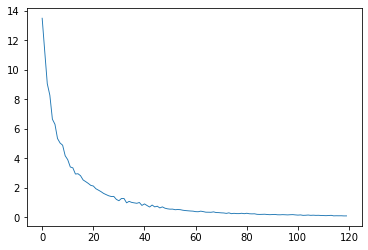

In [670]:
#plt.plot(onp.log(loss_list), linewidth=0.1)

plt.plot(loss_list, linewidth=0.9)
#plt.yscale('log')

In [671]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


# How does it look?

Predict some coordinates and plot to see if they are at least consistent with the expected radial distribution function. 

In [672]:
key, noise_key = random.split(key)
numsamples = 28
noise = random.normal(noise_key, shape=(numsamples, latent_dims))

p = get_params(opt_state)
coords = decode(p, noise).reshape(numsamples,-1)

predicted_samples = list()
for c in coords:
    reshaped = c.reshape(9,3)
    predicted_samples.append(reshaped)


In [673]:
coords

DeviceArray([[-1.35847569e+01, -5.56125879e+00, -1.01247997e+01,
               4.25682116e+00,  1.30326519e+01, -1.49496288e+01,
               7.90887403e+00, -6.36730146e+00, -5.83910704e-01,
               2.53946090e+00,  8.22708797e+00, -5.96512461e+00,
               8.95459270e+00,  1.42053485e+00,  4.62305881e-02,
               8.15996647e+00,  1.37655869e+01, -2.36639643e+00,
               1.31777012e+00,  1.09932156e+01,  1.44443531e+01,
               1.39512024e+01,  1.73381352e+00,  5.04049253e+00,
              -6.32966185e+00, -6.49270630e+00,  1.08653469e+01],
             [ 2.05248375e+01, -1.82426186e+01, -5.94581032e+00,
               1.63600636e+01, -3.34707527e+01,  4.86596489e+01,
              -3.59973793e+01,  1.51376801e+01, -4.31229210e+01,
               7.44593430e+00, -2.02196617e+01,  4.47074127e+01,
              -4.79576302e+01,  1.47443600e+01, -9.12751007e+00,
              -2.88517056e+01, -6.48510590e+01,  3.57888756e+01,
               4.7881977

In [674]:
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

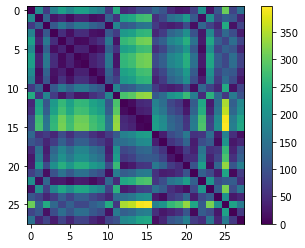

In [675]:
plt.imshow(E_fn(coords))
plt.colorbar()

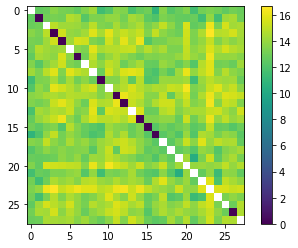

In [679]:
plt.imshow(E_fn(noise))
plt.colorbar()

In [680]:
def E_fn(conf):
    norms = np.sum(conf ** 2, -1)
    dij = np.sqrt(norms[..., None] + norms - 2 * np.dot(conf, conf.T))
    return dij

#plt.imshow(E_fn(coords)[np.triu_indices(numsamples)])
#plt.colorbar()

In [681]:
np.sum(E_fn(coords)[np.triu_indices(numsamples, 1)] / E_fn(noises)[np.triu_indices(numsamples, 1)])

DeviceArray(3430.911, dtype=float32)

In [682]:
np.sum( (E_fn(coords)[np.triu_indices(coords.shape[0], 1)]\
                          / E_fn(noise)[np.triu_indices(noise.shape[0], 1)]) 
                               )

DeviceArray(3447.8235, dtype=float32)

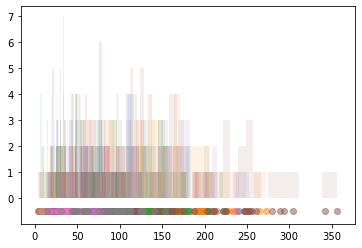

In [683]:
all_distances = list()
for idx in range(numsamples):
    
    coords = predicted_samples[idx]
    distances = pairwise_distances(coords)
    all_distances.append(distances)
    plt.hist(distances, bins=36, alpha=0.1)
    plt.scatter(distances, np.zeros(len(distances))-0.5, alpha=0.5)

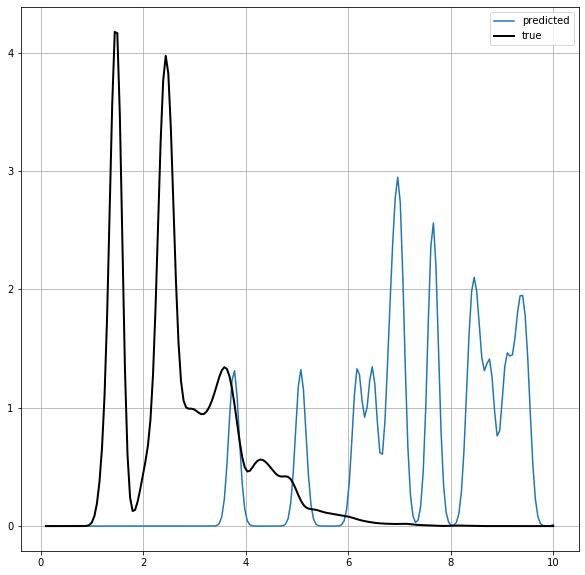

In [684]:
#plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(all_distances).flatten()), label='predicted')

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(all_distances).flatten()), label='predicted')
#for d in all_distances:
#    plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(d).flatten()), linewidth=0.25)
plt.plot(np.linspace(0.1, 10, 200), calcRDF(edms_flat), label='true', c='k', linewidth=2)
plt.grid()
plt.legend()

(0, 10)

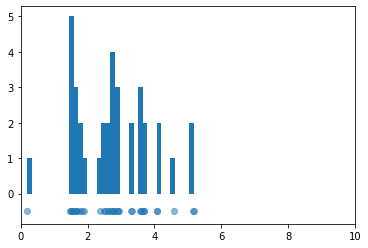

In [619]:
plt.hist(distances, bins=36)
plt.scatter(distances, np.zeros(len(distances))-0.5, alpha=0.5)
plt.xlim(0,10)

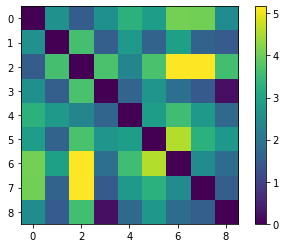

In [620]:
edm = squareform(distances)
plt.imshow(squareform(distances))
plt.colorbar()

In [621]:
#Neater:
#https://github.com/google/jax/issues/1397
    
edm = squareform(all_distances[1])
    

def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = edm**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [632]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.05
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.05
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


--------------
_Remember_ - you can use either the EDM-coords or the real coordinates to generate a molecule



Somehow these are different. They should be the same!!

In [633]:
atomicNumList = [6]*9



#use either 'X' or 'coords'
am, mol =xyz2AC(atomicNumList,coords)

In [634]:

eMol = Chem.EditableMol(mol)

bonds = np.triu(am)
for j, k in zip(onp.where(bonds)[0], onp.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None

0 2
1 3
1 5
1 8
3 7
3 8
7 8


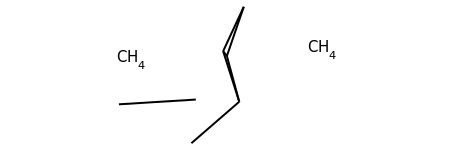

In [635]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

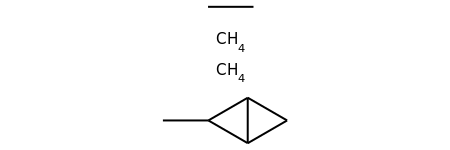

In [636]:
mol.Compute2DCoords()
mol